In [1]:
from sympy import *
import operator
import functools
import math
import pandas as pd
import numpy as np

init_printing()

In [2]:
# class cycle_finder(object):
#     """
#     Adapted from
#     https://stackoverflow.com/questions/12367801/finding-all-cycles-in-undirected-graphs
#     See also
#     http://dspace.mit.edu/bitstream/handle/1721.1/68106/FTL_R_1982_07.pdf
#     #graph = [[1, 2], [1, 3], [1, 4], [2, 3], [3, 4], [2, 6], [4, 6], [8, 7], [8, 9], [9, 7]]
#     graph = [[0,1], [0,2], [1,2], [1,3], [2,3]]

#     for p in cycle_finder(graph): print(p) #returns the edges in the circuit indexed from the graph
#     for p in cycle_finder(graph, "vertices"): # returns the vertices in the cicuit

#     """
#     def __init__(self, graph_edges, c_type="edges"):
#         #i need them sorted here - this is an undirected graph too
#         self.graph = graph_edges#[sorted(l) for l in list(graph_edges)]
#         self.cycles = []  
#         self.c_type = c_type
#         for edge in self.graph:
#             for node in edge:  
#                 self.findNewCycles([node])
    
#     def __expand_edges__(self, vlist):
#         for i,v in enumerate(vlist): 
#             yield sorted([vlist[i-1],v])
            
#     @property
#     def cycle_basis(self):
#         l = list(self)
#         b = np.zeros((len(l),len(self.graph)),np.int)
#         for i,r in enumerate(b): r[l[i]] = 1
#         return b
    
#     def __iter__(self):
#         for cy in self.cycles:
#             res = [node for node in cy]
#             if self.c_type == "vertices": yield res
#             else: yield [self.graph.index(e) for e in self.__expand_edges__(res)]
               
#     def findNewCycles(self,path):
#         def isNew(path): return not path in self.cycles
#         def visited(node, path):  return node in path
#         def invert(path):return rotate_to_smallest(path[::-1])
#         def rotate_to_smallest(path):
#             n = path.index(min(path))
#             return path[n:]+path[:n]   
        
#         start_node,next_node,sub = path[0],None,[]
        
#         for edge in self.graph:
#             node1, node2 = edge
#             if start_node in edge:
#                     next_node = node2 if node1 == start_node else node1
#             if not visited(next_node, path):
#                     sub = [next_node]
#                     sub.extend(path)
#                     self.findNewCycles(sub);
#             elif len(path) > 2  and next_node == path[-1]:
#                     p = rotate_to_smallest(path);
#                     inv = invert(p)
#                     if isNew(p) and isNew(inv):  
#                         self.cycles.append(p)
                        

In [917]:

    
class incidence_matrix(np.ndarray):  
    #things to watch out for - handling multiple edges
    #todo allow a dictionary of letters maybe for vertices to make it easier to init and maybe consider not using sizes
    #alternative loading model where we do not compute the k_matrix?
    #alternative where we do not add the edge count and vertex count - seems a bit inconvenient
    def __new__(self, edge_count, vertex_count, edges=[],external_vertices=[], external_vertex_degrees=None):
        size = (vertex_count+ (1 if len(external_vertices) > 0 else  0),edge_count+len(external_vertices))
        obj = super(incidence_matrix, self).__new__(self, size, np.int)  
        obj[:] = 0 
        obj.add_edges(edges + [[-1,ev] for ev in external_vertices])
        obj._external_vertices = external_vertices
        obj._internal_vertices = list(set(list(range(vertex_count))) - set(external_vertices))
        
        obj._kmatrix = obj.kirchhoff
        obj._betti_1 = obj._kmatrix.degree()#~ whats the relatioship?
    
        obj._num_internal_edges = len(edges)
        
        return obj
         
        
    def ensure_edge_directions(self,d):
        """Supply a dictoinary with edge id and vertex e.g. { 0: [1,2]} means edge 0 takes vertex 1 to vertex 2"""
        for k,v in d.items():self[:,k][v[0]],self[:,k][v[1]] = 1, -1
        
    def flip_edges(self,edge_indecies):
        if not isinstance(edge_indecies,list): edge_indecies =[edge_indecies]
        for e in edge_indecies:self[:,e]*= -1
        return self
        
    def reset_edge_orders(self, edges):pass
    def reset_edge_orders_from_hierarchy(self):pass
    
    def get_all_connections(self,a,b):
        for i,r in enumerate(self.T):
            if(r[a]==1) and (r[b]==-1):yield i, 1
            if(r[a]==-1) and (r[b]==1):yield i, -1
            
    def try_directed_edge_index(self,a,b):
        """
        checks all the columns (edges) to see if there is an edge that starts at a(1) and endgs at b(-1)
        """
        for i,r in enumerate(self.T):
            if(r[a]==1) and (r[b]==-1):
                return i
        return None
    
    def exists_directed_edge(self,a,b):
        return self.try_directed_edge_index != None
    
    @property
    def cycle_basis(self): return cycle_finder(self.edges).cycle_basis
    
    @property
    def edges(self): return [self.directed_edge_as_vertices(e) for e in range(self._num_internal_edges)]
        
    @property
    def internal_vertices (self):return self._internal_vertices
    
    @property
    def external_vertices (self):return self._external_vertices
    
    def get_coincident_vertices_any(self, vset,exclusions = []):
        items = []
        for v in vset:
            for _v in self.get_coincident_vertices(v,exclusions):
                if _v not in items: items.append(_v)
        return items
        
    def get_incident_edges(self, v):return np.nonzero(self[v])[0]
        
    def get_coincident_vertices(self, v,exclusions = []):
        #these are the data columns for which v has edge data
        v_inc_frame = self[:,np.where(self[v]!=0)[0]]
        exclusions = exclusions + [v]
        #now get the row index for things that are co-incident using the trick but just checking non zero rows
        #this is a bit odd and probably better way but count non zero columns uses the count and nonzero combined 
        #and we ensure that v is not in the list which is requred when it has only one edge for example
        #I check if it is incoming or outgoing - we could change it to in and out by changing != 0 to +1
        #the 1 is important for directionality bias e.g. when drawing we only want to draw the directed edge or handle unidirectionality
        incident_vertices = [l for l in list(np.nonzero((np.count_nonzero(v_inc_frame,axis=1)==1).astype(int))[0]) if l not in exclusions]
        return incident_vertices
        
    def add_edges(self, eset):
        for i, v in enumerate(eset): 
            self[v[0],i],self[v[1],i] = 1,-1
            
            
    @property
    def tree_distance_map(self):
        dmap = {}
        for h in INC.vertex_hierarchy():
            for l in h[1]:dmap[l]= h[0]
        return dmap

    def vertex_hierarchy(self, vset=[-1], d=0, h={} ):
        """
        recursion from external nodes or other seed set
        """
        if d ==0: h= {}
        #need to re-think the indexing a little
        #this is so that I can store the last vertex (inf) as either -1 or the length of the thing
        if -1 in vset:h[len(self)-1] = 2
        for _v in vset: h[_v] = d
        if len(vset) > 0:yield d, vset
        #look for any coincident vertices that are not on my level or above
        next_layer = self.get_coincident_vertices_any(vset ,vset+ list(h.keys()))
        if(len(next_layer)>0):
            for t in self.vertex_hierarchy(next_layer,d+1,h):
                yield t
    
   
    def __coincident_vertex__(self, v, e):
        col = self[:,e]
        [e for e in np.where(INC[:,1]!=0)[0] if e != 2][0]
        return [i for i in np.where(col != 0)[0] if i != v][0]
   
    def get_alt_adjacency(self):
        d = {}
        for i,r in enumerate(self):
            eset = self.get_incident_edges(i)
            l = []
            for e in eset: l.append(( self.__coincident_vertex__(i,e),e, "I" if e < len(self.edges) else "E")) 
            d[i] = l
        return d
    
    @property
    def flat_adjacency(self): return [ list(np.nonzero(v)[0]) for v in  self.adjacency_with_inf]
      
    @property
    def adjacency(self):
        #[ np.nonzero(v)[0]for v in  INC.adjacency_with_inf]
        return self.adjacency_with_inf()[:-1,:-1]
  
    def adjacency_with_inf(self,restricted_edges=None,use_edge_labels_1indexed=False):
        ad = np.zeros((len(self),len(self)),np.int)
        for i, v in enumerate(self):  
            if restricted_edges is None or i in restricted_edges:
                #does not work for multiple edges - what do we want to do about this?
                #todo - count how many times it is connected and then create a lookup of edges
                ad[i][self.get_coincident_vertices(i)]  =1 if not use_edge_labels_1indexed else self.get_incident_edges(i)+ 1
        return ad#[:-1,:-1] if len(self._external_vertices) > 0 else ad
    
    @property
    def edge_labels(self):
        #the last row is the external vertex so check which edges are connected
        ex_edges = np.nonzero(self[-1])[0]
        return [ "p"+str(i) for i in range(self.shape[-1]) if i not in ex_edges]   +   [ "q"+str(i) for i in range(len(ex_edges))]
       
    @property
    def vertex_constraints(self,display=False):
        edge_labels = self.edge_labels
        for v in self:
            yield delta_constraint([edge_labels[i] for i in np.nonzero(v)[0]])
            
    @property
    def edge_label_matrix(self): return Matrix(self) * diag( *self.edge_labels)
    
    def constraint_system(self,solve=False): 
        equations = []
        incmat = self.edge_label_matrix
        for i in range(incmat.shape[0]): 
            equations.append(functools.reduce(operator.add, incmat.row(i), 0))
        mat= Matrix(equations)
        return mat if not solve else solve(mat)
        
    @property
    def symbol_adjacency(self):pass
    
    def __sym_i_cofactor__(mat,r=-1,c=-1):
        """remove ith row and ith column"""
        temp = Matrix(mat)
        if r==-1: r = temp.shape[0]-1
        if c==-1: c = temp.shape[1]-1
        temp.col_del(c)
        temp.row_del(r)
        return temp
    
    def _internal_symbols_(self): 
        ex_edges = np.nonzero(self[-1])[0]
        return [Symbol("p"+str(i)) for i in range(self.shape[-1]) if i not in ex_edges]
    
    def _external_symbols_(self): 
        ex_edges = np.nonzero(self[-1])[0]
        return [Symbol("q"+str(i)) for i in range(len(ex_edges))]
    
    @property
    def kirchhoff(self):
        #get the laplacian
        L = self.edge_label_matrix * self.edge_label_matrix.T
        #scale the terms because of the way we did it
        for s in self._internal_symbols_(): L=L.subs({s**2:s})
        #treat all external edges as z so we can get a polynomial in z for forest order
        for s in self._external_symbols_(): L=L.subs({s**2:Symbol("z")}) 
        #take the reduced laplacian
        reduced =  incidence_matrix.__sym_i_cofactor__(L)  
        #solve determinant
        P= reduced.det(method='berkowitz')
        #make it pretty
        res = collect(expand(P),Symbol("z"))
        res = Poly(res, Symbol("z"))
        return res
    
    @property
    def first_betti_number(self): return self._betti_1
    
    @property
    def spanning_trees(self): return pd.DataFrame(self.k_forests(-1))
    
    def k_forests(self, order): 
        p = self._kmatrix.coeffs()[order]
        #this must be considered temporary - one thing might be to use symbols that evaluate to useful things instead of bare symbols
        for monomials in p.as_ordered_terms(): 
            edges = [int(str(e).replace("p","")) for e in monomials.free_symbols]
            yield edges
            
    def edge_complement(self,edges):
        return list(set(range(len(self.edges))) - set(edges))
    
    def directed_edge_as_vertices(self,e):
        """
        the edge goes from cell marked 1 to cell marked -1
        """
        e = self[:,e]
        return [np.where(e==1)[0][0],np.where(e==-1)[0][0]]
            

In [918]:
itest = incidence_matrix(9, 6,
                       [ [0,1], [1,2], [2,0], [3,4],[4,3],[3,0],[4,2], [4,5], [5,3] ],
                       external_vertices=[0,1,2])
itest

incidence_matrix([[ 1,  0, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0],
                  [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0],
                  [ 0, -1,  1,  0,  0,  0, -1,  0,  0,  0,  0, -1],
                  [ 0,  0,  0,  1, -1,  1,  0,  0, -1,  0,  0,  0],
                  [ 0,  0,  0, -1,  1,  0,  1,  1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1]])

In [919]:
pd.DataFrame(itest).iloc[[0,1,2]]

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,0,-1,0,0,-1,0,0,0,-1,0,0
1,-1,1,0,0,0,0,0,0,0,0,-1,0
2,0,-1,1,0,0,0,-1,0,0,0,0,-1


In [973]:
class arc(object):
    def __init__(self, angles, radius,center=None,size=None,pid=None,is_cut_line=False):
        self.pid = pid
        self.radius = radius
        object_radius = 20 + radius
        self.center = (object_radius,object_radius) if center is None else center
        self.size=(2*object_radius,2*object_radius) if size is None else size
        self.body = ""
        self.header =  arc.get_header()
        
        #print(pid, ":angles for pid", angles)
        startAngle,endAngle = angles[0],angles[1]    
        mid_angle = (startAngle+endAngle)/2.
        self._is_cut_line = is_cut_line
        
        #self.body+= """<circle cx="{0}" cy="{1}" r="2" stroke="black" stroke-width="1" fill="red" /> """.format(*self.center)
            
        self.body+= self.__describeArc__(startAngle, endAngle)
        if not self._is_cut_line:
            self.body+= self.__describeArc__(startAngle, mid_angle, decorations="marker-end='url(#arrow)'")
           
    @staticmethod
    def get_header():
                 return """<defs><marker id="arrow"  markerUnits="strokeWidth" markerWidth='5' markerHeight='8' refX='0' refY='2' orient="auto">
                                      <path d="M0,0 V4 L2,2 Z" style="fill: #000000;" /> </marker></defs>"""
     
    
    def __polarToCartesian__(self, angleInDegrees, radius, center):
        centerX, centerY = center[0], center[1]
        angleInRadians = (angleInDegrees-90) *math.pi / 180.0;
        return int( centerX + (radius * math.cos(angleInRadians))), int( centerY + (radius * math.sin(angleInRadians))), angleInDegrees
          
    def __describeArc__(self, startAngle, endAngle, decorations=""):
        radius = self.radius
        wrap,sweepFlag = (0,0) if endAngle < startAngle  else (0,1)

        start = self.__polarToCartesian__(startAngle+wrap, radius, self.center) 
        end = self.__polarToCartesian__(endAngle+wrap, radius, self.center)
        colour = "black"
        largeArcFlag = "0" if endAngle - startAngle <= 180 else "1"
        #print(startAngle+wrap,endAngle+wrap, largeArcFlag, sweepFlag)
        d = [  "M", start[0], start[1], "A", radius, radius, 0, largeArcFlag, sweepFlag, end[0], end[1]  ]
        d = " ".join([str(_d)+" " for _d  in d] )   
        
        transfrm =  ""#  """transform="rotate(180, {}, {}) scale(1, -1) translate(0, -150)" """.format(*self.center) if self.change_sense else ""
        pidattr = "" if self.pid == None else """id='edge{}'""".format(self.pid)
        
        dasharray = "" if not self._is_cut_line else """stroke-dasharray='1,5' """
        
        return """<path {} d="{}" stroke="{}"  stroke-width:3px" {} {} {}/>""".format(pidattr, d,colour, decorations, transfrm, dasharray) 
    
    def __repr__(self):return self.header + self.body
    
    def _repr_html_(self): 
        return   """<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1" x="{1}" y="{2}" width="{3}" height="{4}">
      <g fill="none" stroke="black" stroke-width="1.6" stroke-linecap="round"> {0}  </g> </svg>""".format(self.__repr__(),  *self.center, *self.size)

#arc((130,250),radius=50,change_sense=False)

class ring_diagram(object):
    """
    This one uses a concentric circle arrangement starting from nodes connected to v_\{infty}
    This is a rough prototype to play around with the SVG
    Actually this needs a better integration with the incident matrix i.e. the incident matrix needs some concepts
    that are used in drawing such as drawing callbacks for arcs and edges mapped to a coodinate system
    then we should be able to enumerate through all arcs and edges in the diagram
    that would make it easy to show only one edge w.r.t the origin and be alot more functional
    important thing is to make sure the drawing is driven from the incidence matrix 
    this avoids the problem of connecting out to the outer rings which was just a test run
    the incident matrix then needs to be validated by independent cycles
    """
    def __init__(self, inc_matrix, options={}):
        self.x = 0
        self.y = 0
        self.margin = 10
        self.radius = 90
        center = self.radius+self.margin
        self._size=(200,200)
        self._center = (center,center)
        self._options = options
        self._inc = inc_matrix
        self._vertex_depths = [v[1] for v in list(self._inc.vertex_hierarchy())][1:]
        self._metadata = {}
        self.body = ""
        
        #for spanning tree - this is not general enough but quick fix
        self._dashed_edges = [] if not "cut_edges" in options else options["cut_edges"]
            
    @property
    def external_vertices(self):mpass

    def __circuit_permutations__(self):
        #so for all adjacency matrix entries, permute so as to choose a particular cycle set
        #oursource to algorithm
        yield None
        
    def __circuit_edge_permutations__(self):
        #for each cycle set, choose the independent cylces by fixing an edge delegate in each independent cicuit
        yield None
        
    def __measure_inter_layer_chords__(self, existing_coords, proposed_coords):
        return 0
    
    def __polarToCartesian__(self, angleInDegrees, radius, center):
        centerX, centerY = center[0], center[1]
        angleInRadians = (angleInDegrees-90) *math.pi / 180.0;
        return int( centerX + (radius * math.cos(angleInRadians))), int( centerY + (radius * math.sin(angleInRadians))), angleInDegrees
    
    def __set_vertex_property__(self, i, key, value):
        if i not in self._metadata: self._metadata[i] = {}
        self._metadata[i][key] = value
        
    def __get_vertex_property__(self, i, key,value):
        if i in self._metadata and key in self._metadata[i]:return self._metadata[i][p]
    
    def __arrange__(self, angle, radius, vset, center=None, prev_layer_connections={}):
        center = center if center is not None else self._center
        if angle == 360: 
            self.__set_vertex_property__(vset[0], "point", center)
            return [center]#if the angle is 360 this can only be a dot in the center
        m,accepted = 1,None
        for offset in [angle]:
            proposed = [self.__polarToCartesian__( (i+1)*angle, radius,center) for i, v in enumerate(vset)]
            _m = self.__measure_inter_layer_chords__(prev_layer_connections, proposed)
            if m ==-1 or _m < m: 
                accepted, m = proposed, _m
                for i,v in enumerate(vset):
                    self.__set_vertex_property__(v, "point", [proposed[i][0],proposed[i][1]])
                    self.__set_vertex_property__(v, "angle", proposed[i][-1])
                    self.__set_vertex_property__(v, "radius", radius)
                            
        return accepted

    def __describeArc__(self, startAngle, endAngle, radius,pid=None):
        return arc((startAngle,endAngle),radius, self._center,self._size, pid=pid, is_cut_line=(pid in self._dashed_edges)).body    
           
    def try_get_connecting_edges(self, v):
        #look up the metadata for v and get all edges that are adjacent to it that we know about
        #think about us and vs here - i may be mixing them up
        for u in self._inc.get_coincident_vertices(v):
            if u in self._metadata and v in self._metadata: 
                _u,_v = u,v
                #if the max length is exceeded, try to get a nice arc otherwise....
                #max length is the length of the verticle chord connecting the bottom of one disk to the point on the outer disk          
                pid = self._inc.try_directed_edge_index(_v,_u)
                if pid == None: 
                    _u,_v = _v,_u #flip for drawing
                    pid = self._inc.try_directed_edge_index(_v,_u)
                    
                #print("edge pid for", _u, _v, pid)
                
                yield self.get_line([self._metadata[_u]["point"][0],
                                     self._metadata[_u]["point"][1],
                                     self._metadata[_v]["point"][0],
                                     self._metadata[_v]["point"][1]],
                                     pid=pid)
        
    def get_line(self, pts, colour="black", dash_array=None,pid=None):
        
        midpoint = [(pts[0] + pts[2])/2.,(pts[1] + pts[3])/2.]            
        #l = """<line x1="{0}" y1="{1}" x2="{2}" y2="{3}" stroke="{4}" stroke-width:2px"  {5}   />""".format(*pts, colour,dash_array )
        pidattr = "" if pid == None else """id='edge{}'""".format(pid)
        dasharray =  "" if pid not in self._dashed_edges else """stroke-dasharray='1,7'"""
        hl =""
        l = """<path d="M{0} {1} L {2} {3}" stroke="{4}" stroke-width:2px" {5} {6}  /> """.format(*pts, colour,pidattr,dasharray )
        #print(l)
        if pid not in self._dashed_edges:#only display if not cut edge
            hl = """<line x1="{0}" y1="{1}" x2="{2}" y2="{3}" stroke="{4}" stroke-width:2px"  {5}  marker-end='url(#arrow)' />""".format(pts[0], pts[1], midpoint[0], midpoint[1], colour,dash_array )
        return l+hl
    
    def __edge_segments__(self,a,b,angle, radius, vset):
        #clean this up; assume that we have a vset but we dont know what the angles are
        #we assume that they are connected in a ring (works for multiple edge)?
        #the incidence matrix must start 1 and go -1 to check if the edge exists in that way as we have assumed a layout here
        """
        We always arrange vertices on disks separated by angles. Can only have vertices in [0,360]
        We assume that the id is the arrangment id in order and that a<b for normal sense
        if however b<a, then we have anticlockwise sense and we will change the angles for downstream reflection
        """
        #if there are multiple edges, then allow - otherwise restrict direction - wrapping because its a ring
        a,b = a%len(vset),b%len(vset)
        offset_angles = [self.__polarToCartesian__( (i+1)*angle, radius,self._center) for i, v in enumerate(vset)]
        
        first = offset_angles[a][-1] % 360 # we should always start 
        second = offset_angles[b][-1] 
        
        all_con = list(self._inc.get_all_connections(a,b))
        if len (all_con) > 0: print("mili edges detected")
        
        pid = self._inc.try_directed_edge_index(vset[a],vset[b])
        if pid == None:
            a,b = b,a
            first,second = second,first
            pid = self._inc.try_directed_edge_index(vset[a],vset[b])

        cap = lambda x : 0 if x == 360 else x     
        if a< b: return (first,second), pid
        return (first,cap(second)), pid

    def arrange_edges(self): 
        inc = self._inc
        MD = self._metadata
        def same_ring(a,b):
            if "radius" in MD[a] and "radius" in MD[b]:
                if MD[a]["radius"] == MD[b]["radius"]:return True
            return False      
        for p in MD.keys():
            for q in self._metadata.keys():
                if p >q:continue #diag
                pq_cons = list(inc.get_all_connections(p,q))
                for i, edge_meta in enumerate(pq_cons):
                    a,b = (p,q) if edge_meta[-1] == 1 else (q,p) #check convention
                    edge = [a,b]
                    edge_id = edge_meta[0]
                    
                    if i > 1 or not same_ring(a,b): #max ring links or on a different ring
                        self.body +=self.get_line([self._metadata[a]["point"][0],self._metadata[a]["point"][1],
                                       self._metadata[b]["point"][0],self._metadata[b]["point"][1]],
                                       pid=edge_id)
                    else: 
                        angles = [MD[a]["angle"],MD[b]["angle"]]
                        if i == 1:
                            angles = [angles[0]%360,angles[1]%360] 
                        #temp hack
                        if angles[0] - angles[1] >180 and angles[0] == 360:angles[0]=0
                        print(edge_id,angles,i)
                        self.body += self.__describeArc__(*angles, MD[a]["radius"], pid=edge_id )

    def __display__(self):
        ##arrangement algorithm
        #each level of the hiearchy is given a radius >= 0 and maximally seperated items are added
        #there are symmetric locations and these are chosen to minimise arc lengths
        #I think maybe just try rotations of some integer factors of the freedom which is 360/|l| not including the one that gives the symmetry of course      
        marker_style = arc.get_header()
        self.body += marker_style
        levels = len(self._vertex_depths)
        
        radii_margins = [20*(levels-(i)) for i in reversed(range(len(self._vertex_depths))) ]
        angles = [(360./len(v)) for v in self._vertex_depths]
        for i, vset in enumerate(self._vertex_depths): 
            radius = self.radius-radii_margins[i]
            for coord in self.__arrange__(angles[i],radius , vset):
                self.body+= """<circle cx="{0}" cy="{1}" r="3" stroke="black" stroke-width="1" fill="black" /> """.format(*coord)
                
#             for j,v in enumerate(vset):#make loops
#                 if len(vset) == 1: continue
#                 edge, pid = self.__edge_segments__(j,j+1,angles[i],radius,vset)
#                 #print(pid,edge)
#                 self.body += self.__describeArc__(*edge, radius, pid=pid )

#             if i > 0:#after the first layer, connect edges inter-layer
#                 for v in vset: 
#                     for e in self.try_get_connecting_edges(v):  self.body += e
                    
        if "show_labels" in self._options:
                for e in range(len(self._inc.edges)):
                    self.body+= """<text x="10%" style="fill: #000000;stroke: none; font-size: 14px;" ><textPath xlink:href="#edge{0}">e{0}</textPath></text>""".format(e)
        
        self.arrange_edges()
                    
        return  """<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1" x="{1}" y="{2}" width="{3}" height="{4}">
      <g fill="none" stroke="black" stroke-width="1.6" stroke-linecap="round"> {0}  </g> </svg>""".format(self.body,  self.x, self.y, *self._size)

    #def __repr__(self):return self.__display__()           
    def __div2s__(self,n):
        while n - int(n) == 0:
            n/=2
            if n - int(n) ==0: yield n

                
    def _repr_html_(self): return self.__display__()
    
    @property
    def vertex_delta_functions(self):
        pass
    
    @property
    def loop_delta_functions(self):
        pass
                   
            
class show_spanning_trees(object):
    def __init__(self, inc_matrix, show_labels=False, max_width=None):
        
        total_edges = len(inc_matrix.edges)
        
        trees = inc_matrix.spanning_trees
        #todo limit the width so we do not have some crazy amount 
        l = int(np.ceil(np.sqrt(len(trees))))
        #complement - cut the edges not in the tree
        edges_too_cut= [list(set(range(total_edges))-set(list(v))) for k, v in trees.iterrows()]
        rows = ""
        counter = 0
        for i in range(l):
            row = "<tr>"
            for j in range(l):
                if counter == len(edges_too_cut):break
                o = options={"cut_edges": edges_too_cut[counter]}
                if show_labels: o["show_labels"] = True
                rd = ring_diagram(inc_matrix.copy(), options=o)
                row+="<td>{}</td>".format(rd.__display__() )
                counter+=1
            row+= "</tr>"
            rows+= row
                
        self.body = """<table>{}</table>""".format(rows)
        
    def _repr_html_(self): return self.body



In [974]:
INC = incidence_matrix(9, 6,
                       [ [0,1], [1,2], [2,0], [3,4],[4,3],[3,0],[4,2], [4,5], [5,3] ],
                       external_vertices=[0,1,2])
INC.flip_edges(1)
D = ring_diagram(INC, options={ "show_labels":True, }) 
D

0 [120.0, 240.0] 0
2 [0, 120.0] 0
1 [360.0, 240.0] 0
3 [180.0, 360.0] 0
4 [0.0, 180.0] 1


In [975]:
INC = incidence_matrix(3,2,
                       [ [1,0], [1,0], [0,1]],
                       external_vertices=[0,1])
D = ring_diagram(INC, options={ "show_labels":True, }) 
D

0 [360.0, 180.0] 0
1 [0.0, 180.0] 1


In [978]:
def _adj_struct_from_edges_(inc_mat, eset):
    tuples = []
    for e in eset:
        t = list(np.where(inc_mat[:,e]!=0)[0])
        tuples.append(t+[e])
        tuples.append(list(reversed(t))+[e])
    df = pd.DataFrame(tuples,columns=["a","b", "e"]).sort_values("a")
    tds = pd.DataFrame([[k,v] for k,v in INC.tree_distance_map.items()],columns=["v", "d"])
    return pd.merge(df,tds, left_on="a", right_on="v")

def random_walk(adj, nedges,i=0,j=0, max_length=100, min_path_length=1, set_edge_sense=None):
    """Random walk on edge boolean space until we construct a path of length greater than 1 using a clever backtrack trick"""
    
    l = 0 #safety
    epath = np.zeros(nedges, bool)
    _i = i   
    def _random_choice_(adj,i):
        mat = adj[adj["a"]==i][["e", "b"]].as_matrix()
        return tuple(mat[np.random.randint(len(mat))])
    ###################################################
    loop_formed = lambda : epath.sum() > min_path_length and _i == i 
    while l < max_length and not loop_formed():
        e, _i = _random_choice_(adj, _i )
        #print(e,_i)
        epath[e] = np.logical_not(epath[e])
        l+=1   
    if not loop_formed():epath=False 
    ####################################################
    #return epath
    return list(np.where(epath)[0])
    
def circuits(inc_matrix, spanning_tree=None):  
    if spanning_tree is None:spanning_tree = inc_matrix.spanning_trees.iloc[0].values
    st_comp = inc_matrix.edge_complement(spanning_tree)
    #this spanning tree must have L missing edges
    all_circuits = []
    for e in st_comp:#add one edge and determine it's incident vertex to start a circuit trace
        ev = inc_matrix.directed_edge_as_vertices(e)
        #print("edge",e, "is", ev)
        sub_tree = [e] + list(spanning_tree)
        #print(sub_tree)
        adj = _adj_struct_from_edges_(inc_matrix,sub_tree)
        circuit = list(random_walk(adj,len(inc_matrix.edges), ev[0],ev[0]))
        all_circuits.append(circuit)      
    return all_circuits

# now take a look at one of the spanning rees

In [980]:
tree = INC.spanning_trees.iloc[0].values
tree_cuts = INC.edge_complement(tree)
print(tree_cuts)
C = ring_diagram(INC, options={"show_labels" :True,  "cut_edges": tree_cuts}) 
C#._repr_html_()

[1, 2]
0 [180.0, 360.0] 0
1 [0.0, 180.0] 1


# Edge Orientations
given cicuits, we can actually rank them by closeness to root and then we can incrementally orientate them in different ways

(1) Choose a source and sink delegate on each circuit and have allow flow towards the sink

(2) Respect loop momentum

In [981]:
#todo the last circuit is degenerate
tree = INC.spanning_trees.iloc[0].values
all_circuits = circuits(INC,tree)
print(all_circuits)

[[0, 1], [0, 2]]


In [837]:
def _ensure_edge_path_(edges):
    "there should be a path from vertex to vertex in the correct order"
    edges = list(edges)
    for i in range(len(edges)-1):
        if edges[i][-1] == edges[i+1][0]:pass
        elif edges[i][-1] == edges[i+1][-1]:edges[i+1] =list(reversed(edges[i+1]))
        else:edges[i] =list(reversed(edges[i]))
    return edges

def set_circuit_flow(inc_mat, circ, entrainment={} ):
    circ_evs = [inc_mat.directed_edge_as_vertices (e) for e in circ]
    circ_evs = _ensure_edge_path_(circ_evs)
    INC.ensure_edge_directions(dict(zip(circ, circ_evs)))
    
def set_source_sink_flow(inc_mat, circ,maxout=100):
    source,sink = tuple(adj[adj["e"].isin(circ)][["v","d"]].drop_duplicates().sort_values("d")[:2]["v"].values)
    #partition the circuit between source and sink
    circ_evs = [inc_mat.directed_edge_as_vertices (e) for e in circ]
    circ_evs = _ensure_edge_path_(circ_evs)   
    S,s = -1,-1
    cursor = 0
    p1 = []
    print("source, sink:",source,sink)
    while s == -1:
        index = cursor%len(circ_evs)
        v = circ_evs[index]
        #print(index, v)
        if v[0] == source:S = index
        if v[0] == sink and S != -1:s = index  
        if S != -1 and s == -1:p1.append(index)
        cursor+= 1
        
        if cursor == maxout:return
    p2 = list(set(range(len(circ))) - set(p1))
    #return [circ_evs[e] for e in p1],[list(reversed(circ_evs[e])) for e in p2]
    #keep one side and reverse the other
    new_edges = [circ_evs[e] for e in p1] + [list(reversed(circ_evs[e])) for e in p2]
    edge_ids = [circ[i] for i in p1+p2]
    d = dict(zip(edge_ids, new_edges))
    INC.ensure_edge_directions(d)
    

# set default circuit flow

In [983]:
circ = all_circuits[1]
set_circuit_flow(INC,circ)
ring_diagram(INC, options={"show_labels" :True,  "cut_edges": INC.edge_complement(circ)}) 

0 [180.0, 360.0] 0
1 [0.0, 180.0] 1


# circuit source sink flow

In [888]:
circ = all_circuits[0]
set_source_sink_flow(INC,circ)
ring_diagram(INC, options={"show_labels" :True,  "cut_edges": INC.edge_complement(circ)}) 

source, sink: 3 4


In [889]:
INC

incidence_matrix([[-1,  0, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0],
                  [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0],
                  [ 0, -1,  1,  0,  0,  0, -1,  0,  0,  0,  0, -1],
                  [ 0,  0,  0,  1,  1,  1,  0,  0,  1,  0,  0,  0],
                  [ 0,  0,  0, -1, -1,  0,  1, -1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  1, -1,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1]])

In [861]:
#rank circuits and apply the above again
circ
INC.edge_complement(circ)

In [ ]:
#now update so that we are entrained by the previous loops - tihs just means that whatever vertex I flow into

In [653]:

ring_diagram(INC, options={"show_labels" :True,  "cut_edges": tree_cuts}) 

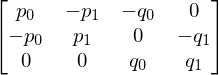

In [281]:
simp = incidence_matrix(2,2,
                       [ [0,1], [1,0],  ],
                       external_vertices=[0,1])
simp.edge_label_matrix

In [144]:
ring_diagram(simp)

In [145]:
simp.constraint_system(solve)

In [ ]:
def source_sink_flip_walk(directed_adj,i,j,updatable_inc=False,forbid_edges=[]):
    """
    walk flipping all edges after us so we cannot walk back from i to j
    when we arrive at j, walk backwards to the last high rank node reversing edges
    add full set to forbidden edges at the end
    """
    return []

def set_default_flow(inc, spanning_tree):
    fixed_edges = np.zeros(len(inc.edges))
    n = len(fixed_edges)
    st_c = list(set(range(n)) - set(spanning_tree))
    print(st_c,st)
    updated_edges = []
    for i in st_c: updated_edges += source_sink_flip_walk(None,i,i,inc, forbid_edges=updated_edges)
        
st = list(inc.spanning_trees.iloc[0].values)
set_default_flow(INC,st )

In [ ]:
edges = st+[2]
edges

In [ ]:
adj = _adj_struct_from_edges_(INC,edges )
adj

In [ ]:
#starting from the higest ranking loops
#perform a walk from designated highest rank (sink) to highest rank (sink) and fix the sense to a loop
#then depending on the mode, walk from dual (source) and flip the edges
#lock edges in the incidence matrix at each level

In [ ]:
show_spanning_trees(INC,show_labels=False)